In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# import uniform distribution
from scipy.stats import uniform
from scipy.stats import binom
from scipy.stats import norm
import scipy.special as sc
import scipy.optimize
from scipy.optimize import fsolve
import time
from scipy.stats import truncnorm
np.random.seed(5)

In [2]:
def auction_exp(data_auction, p):
    """auction experiment simulation

    Args:
        data_auction: random sample data for auction simulation
        p: the reserve price
        
    Return:
        revenue: the expected revenue
    """
    revenue = 0
    for bid in data_auction:
        if bid >= p:
          #change the bidder with price p
          revenue += p
    
    revenue = revenue/len(data_auction)
    return revenue

In [3]:
def rejection_sampling(pi1, pi2, N):
    """rejection sampling algorithm

    Args:
        pi1,pi2: the range of log-lottery distribution
        N: the number of samples from the log-lottery distribution
        
    Return:
        rej_sample: The random samples from the log-lottery distribution
    """

    #using rejection sampling, get N random price samples
    n = 0
    don = pi2*np.log(pi2/pi1) - (pi2-pi1)
    env =(pi2/pi1-1)/don
    rej_sample =[]
    while(n <= N):
        x = uniform.rvs(loc=pi1, scale=pi2-pi1)
        #a is acception probability
        a = (pi2/x-1)/don/env
        u1 = uniform.rvs()
        if (u1 <= a):
            rej_sample.append(x)
            n += 1
    return rej_sample

In [4]:
# Experiment 
#First to test if numerical solver works properly or not

#Definition 3.1: rho_D function used to compute DAPX
def rho_D(x):
    return ((x-1)**3)/((2*x-1)**2) - r**2   

#Definition 5.1:  rho function used to compute the APX theoretical upper bound
def random_rho(x):
    return ((2*np.exp(x-1)-1)-(x**2)*r**2 - x**2)

#Function f used to solve pi1 for log-lottery distribution
def f(x):
    return (x * (1 + np.log(k2/(x**2) + 1) - np.log(2)) -mean )

#function F is used to solve the reserve price for the optimal auction for truncated normal distributions
def F(x):
    return x-((1-truncnorm.cdf(x, a , b ,loc = u,scale = sigma))/truncnorm.pdf(x, a , b ,loc = u,scale = sigma))

step1 =np.linspace(0, 1,40)
step2 =np.linspace(1, 7,20)
n = 100000
myclip_a = 0
myclip_b = np.inf
u = 1 # set mean of the normal distribution to 1 before truncation 

step = np.concatenate((step1,step2))
#step = np.linspace(0, 1,1)
for i in step:
    sigma = 0.01 + i
    #computer alpha beta for truncated normal distribution
    a, b = (myclip_a - u) / sigma, myclip_b

    #mean and variance of truncated normal distribution
    mean, var = truncnorm.stats(a , b ,loc = u,scale = sigma, moments='mv')
    r = np.sqrt(var)/mean

    #experiment with Giannakopoulos et al. auction#######################
    p_d = fsolve(rho_D, [mean])

    print(rho_D(p_d))

    ######################################################################
    
    #Following we experiment the optimal auction for uniform distribution
    p_opt = fsolve(F, mean-0.1)

    ########################################################################
    
    #First solve pi1 and pi2 using numerical solver and then generate the samples from 
    #the corresponding log-lottery distribution.
    k2 = mean**2 + var
    pi1 = fsolve(f, [mean-0.1])
    print(f(pi1))
    #print(pi1,pi2)

   
    #compute the APX theoretical upper bound using function rho from Definition 4.1
    r_rho = fsolve(random_rho, [mean+1])

    print(random_rho(r_rho))



[-1.43182449e-16]
[0.]
[2.22044605e-16]
[-2.04719054e-15]
[-3.33066907e-16]
[0.]
[-2.33753988e-16]
[-2.22044605e-16]
[1.99840144e-15]
[5.20417043e-18]
[0.]
[1.04360964e-14]
[6.9388939e-18]
[0.]
[4.4408921e-16]
[-3.46944695e-18]
[-2.22044605e-16]
[4.4408921e-16]
[-1.38777878e-17]
[-8.8817842e-16]
[0.]
[-7.97972799e-16]
[2.22044605e-16]
[0.]
[-8.21565038e-15]
[1.99840144e-15]
[0.]
[-8.32667268e-17]
[0.]
[0.]
[1.38777878e-17]
[2.22044605e-16]
[1.56763491e-13]
[1.38777878e-17]
[0.]
[4.4408921e-16]
[-4.71844785e-16]
[0.]
[0.]
[-4.16333634e-17]
[8.8817842e-16]
[8.8817842e-16]
[-2.77555756e-17]
[2.22044605e-16]
[8.8817842e-16]
[0.]
[0.]
[-2.39808173e-14]
[0.]
[3.77475828e-15]
[0.]
[5.74540415e-15]
[1.17683641e-14]
[1.687539e-14]
[1.05471187e-15]
[8.65973959e-15]
[-8.8817842e-16]
[2.77555756e-17]
[2.22044605e-16]
[-1.38555833e-13]
[-2.77555756e-17]
[2.22044605e-16]
[8.8817842e-16]
[-5.55111512e-17]
[0.]
[-1.33226763e-14]
[5.55111512e-17]
[8.8817842e-16]
[-3.80140364e-13]
[-1.11022302e-16]
[2.2

In [ ]:
# Experiment deterministic and randomized auctions for single-item and single-bidder case with truncated normal distribution

DAPX_tnorm = []
r_list =[]
r_rho_list=[]
p_d_list = []
p_opt_list =[]
APX_tnorm_list = []

#Definition 3.1: rho_D function used to compute DAPX
def rho_D(x):
    return ((x-1)**3)/((2*x-1)**2) - r**2   

#Definition 5.1:  rho function used to compute the APX theoretical upper bound
def random_rho(x):
    return ((2*np.exp(x-1)-1)-(x**2)*r**2 - x**2)

#Function f used to solve pi1 for log-lottery distribution
def f(x):
    return (x * (1 + np.log(k2/(x**2) + 1) - np.log(2)) -mean )

#function F is used to solve the reserve price for the optimal auction for truncated normal distributions
def F(x):
    return x-((1-truncnorm.cdf(x, a , b ,loc = u,scale = sigma))/truncnorm.pdf(x, a , b ,loc = u,scale = sigma))


step1 =np.linspace(0, 1,40)
step2 =np.linspace(1, 7,20)
n = 100000
myclip_a = 0
myclip_b = np.inf
u = 1 # set mean of the normal distribution to 1 before truncation 
tic = time.clock()
step = np.concatenate((step1,step2))
#step = np.linspace(0, 1,1)
for i in step:
    sigma = 0.01 + i
    #computer alpha beta for truncated normal distribution
    a, b = (myclip_a - u) / sigma, myclip_b

    #mean and variance of truncated normal distribution
    mean, var = truncnorm.stats(a , b ,loc = u,scale = sigma, moments='mv')
    r = np.sqrt(var)/mean
    r_list.append(r)
    #prepare the random samples
    bid_tnorm = truncnorm.rvs(a , b , loc = u,scale = sigma,size=n)
    #experiment with Giannakopoulos et al. auction#######################
    p_d = fsolve(rho_D, [mean])
    p_d_list.append(p_d)
    print(rho_D(p_d))
    reserve_p = p_d*mean/(2*p_d-1)
    exp_revenue = auction_exp(bid_tnorm,reserve_p)
    ######################################################################
    
    #Following we experiment the optimal auction for uniform distribution
    p_opt = fsolve(F, mean-0.1)
    p_opt_list.append(p_opt)
    print(F(p_opt))
    opt = auction_exp(bid_tnorm,p_opt)
    ########################################################################
    
    #Compute the experimental DAPX
    DAPX_tnorm.append((opt/exp_revenue)[0])    

    #First solve pi1 and pi2 using numerical solver and then generate the samples from 
    #the corresponding log-lottery distribution.
    k2 = mean**2 + var
    pi1 = fsolve(f, [mean-0.1])
    pi2 = 0.5*(k2/pi1 +pi1)  
    print(f(pi1))
    #print(pi1,pi2)

    rexp_revenue_list=[]
    rej_sample=[]
    rej_sample = rejection_sampling(pi1,pi2,10000)
    #For each reserve price, perform auction experiment and save all the results
    for rp_reserve in rej_sample:
        rexp_revenue_list.append(auction_exp(bid_tnorm,rp_reserve))
    #Determine the experimental APX with optimal revenue against the average revenue
    APX_tnorm_list.append(opt/np.average(rexp_revenue_list)) 

    #compute the APX theoretical upper bound using function rho from Definition 4.1
    r_rho = fsolve(random_rho, [mean+1])
    r_rho_list.append(r_rho[0])
    print(random_rho(r_rho))

toc = time.clock()
print('time: ' + str(toc-tic))


C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[-1.43182449e-16]
[-1.55431223e-14]
[0.]
[2.22044605e-16]
[-2.04719054e-15]
[-1.73858705e-11]
[-3.33066907e-16]
[0.]
[-2.33753988e-16]
[1.11022302e-15]
[-2.22044605e-16]
[1.99840144e-15]
[5.20417043e-18]
[8.8817842e-16]
[0.]
[1.04360964e-14]
[6.9388939e-18]
[2.5313085e-14]
[0.]
[4.4408921e-16]
[-3.46944695e-18]
[-1.11022302e-16]
[-2.22044605e-16]
[4.4408921e-16]
[-1.38777878e-17]
[5.13922238e-13]
[-8.8817842e-16]
[0.]
[-7.97972799e-16]
[0.]
[2.22044605e-16]
[0.]
[-8.21565038e-15]
[-1.33892897e-13]
[1.99840144e-15]
[0.]
[-8.32667268e-17]
[-8.8817842e-16]
[0.]
[0.]
[1.38777878e-17]
[0.]
[2.22044605e-16]
[1.56763491e-13]
[1.38777878e-17]
[-2.22044605e-16]
[0.]
[4.4408921e-16]
[-4.71844785e-16]
[3.87467836e-14]
[0.]
[0.]
[-4.16333634e-17]
[1.33226763e-15]
[8.8817842e-16]
[8.8817842e-16]
[-2.77555756e-17]
[0.]
[2.22044605e-16]
[8.8817842e-16]
[0.]
[2.22044605e-16]
[0.]
[-2.39808173e-14]
[0.]
[0.]
[3.77475828e-15]
[0.]
[5.74540415e-15]
[0.]
[1.17683641e-14]
[1.687539e-14]
[1.05471187e-15]
[7

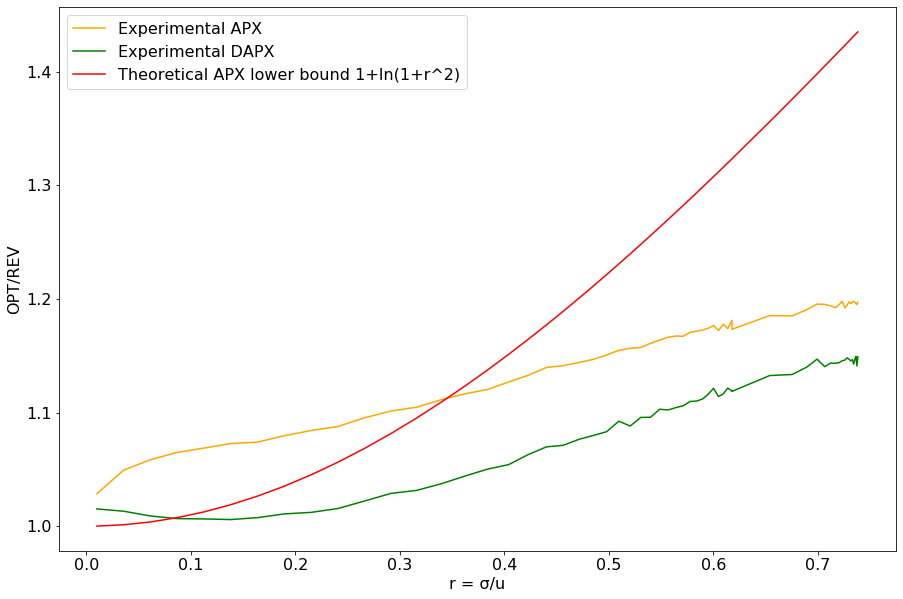

In [43]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 16)
plt.tick_params(axis='y', labelsize= 16)
plt.xlabel("r = \u03C3/u",fontsize=16)
plt.ylabel("OPT/REV",fontsize=16)
plt.plot(r_list, APX_tnorm_list,color="#FFA500",label="Experimental APX")
plt.plot(r_list, DAPX_tnorm,color="green",label="Experimental DAPX")
lower_bound = 1+np.log(1+np.power(r_list,2))
#plt.ylim(0.95,1.5)

#plt.plot(r_list, r_rho_list,color="blue",label="Theoretical APX upper bound \u03C1")
plt.plot(r_list, lower_bound,color="red",label="Theoretical APX lower bound 1+ln(1+r^2)")
plt.legend(loc="upper left",fontsize = 16)
#plt.savefig("apxtnorm2.png",bbox_inches='tight')
plt.show()

In [41]:

import pandas as pd 
lower_bound = 1+np.log(1+np.power(r_list,2)) 
# creating the DataFrame 
my_df = { 'r' : r_list,
          'DAPX_tnorm': DAPX_tnorm,
         'theoretical DAPX':p_d_list,
         'APX_tnorm_list': APX_tnorm_list,
         'upper_bound':r_rho_list,
         'lower_bound':lower_bound
         } 
df = pd.DataFrame(my_df) 
  
   
# saving the DataFrame as a CSV file 
gfg_csv_data = df.to_csv('apx_tnorm.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data) 



CSV String:
 None
